# Hands-on 07: Autoencoders: Anomaly detection

This week, we will look at autoencoders for anomaly detectiopn.

In [108]:
import jetnet
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


im_size = 32
jet_r = 0.8

# download the validation data (400k jets, which is plenty for our purposes)
# full dataset is available here: https://doi.org/10.5281/zenodo.2603255
data = jetnet.datasets.TopTagging(
    jet_type="all",
    particle_features=["E", "px", "py", "pz"],
    jet_features=["type"],
    split="valid",
    data_dir="data/",
    particle_transform=jetnet.utils.cartesian_to_relEtaPhiPt,
)

KeyboardInterrupt: 

In [ ]:
# transform the data
transformed_particle_data = data.particle_transform(data.particle_data)

In [ ]:
# split qcd background and top quark signal
qcd_data = transformed_particle_data[data.jet_data[:, 0] == 0]
top_data = transformed_particle_data[data.jet_data[:, 0] == 1]

In [ ]:
from sklearn.model_selection import train_test_split

qcd_train, qcd_test = train_test_split(qcd_data, test_size=0.2, random_state=42)
_, top_test = train_test_split(top_data, test_size=0.2, random_state=42)

In [ ]:
import numpy as np

#  convert full dataset
qcd_train_images = np.expand_dims(jetnet.utils.to_image(qcd_train, im_size=im_size, maxR=jet_r), axis=-1)
qcd_test_images = np.expand_dims(jetnet.utils.to_image(qcd_test, im_size=im_size, maxR=jet_r), axis=-1)
top_test_images = np.expand_dims(jetnet.utils.to_image(top_test, im_size=im_size, maxR=jet_r), axis=-1)

# rescale so sum is 1 (it should be close already)
qcd_train_images = qcd_train_images / np.sum(qcd_train_images.reshape(-1, 1, 1, 1, im_size * im_size), axis=-1)
qcd_test_images = qcd_test_images / np.sum(qcd_test_images.reshape(-1, 1, 1, 1, im_size * im_size), axis=-1)
top_test_images = top_test_images / np.sum(top_test_images.reshape(-1, 1, 1, 1, im_size * im_size), axis=-1)

In [111]:
def plot_jet_images(images, titles, filename="jet_image.pdf"):

    n_images = len(images)
    plt.figure(figsize=(5 * n_images, 5))

    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, n_images, i + 1)
        plt.title(title)
        plt.imshow(image, origin="lower", norm=LogNorm(vmin=1e-3, vmax=1))
        cbar = plt.colorbar()
        plt.xlabel(r"$\Delta\eta$ cell", fontsize=15)
        plt.ylabel(r"$\Delta\phi$ cell", fontsize=15)
        cbar.set_label(r"$p_T/p_T^{jet}$", fontsize=15)

    plt.tight_layout()
    plt.savefig(filename)

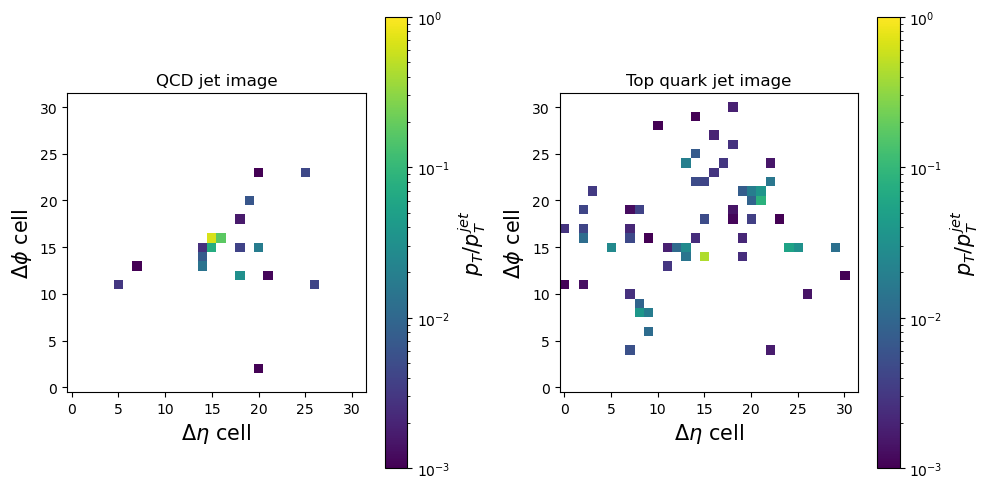

In [112]:
plot_jet_images([qcd_test_images[0], top_test_images[0]], ["QCD jet image", "Top quark jet image"])

In [113]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Reshape, Flatten, Activation, UpSampling2D, Softmax

x_in = Input(shape=(im_size, im_size, 1))
x = Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same")(x_in)
x = MaxPooling2D(pool_size=(2, 2), padding="same")(x)
x = Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2), padding="same")(x)
x = Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = Flatten()(x)
x = Dense(32, activation="relu")(x)
x_enc = Dense(4, name="bottleneck")(x)

x = Dense(32, activation="relu")(x_enc)
x = Dense(int(im_size * im_size / 16) * 128, activation="relu")(x)
x = Reshape((int(im_size / 4), int(im_size / 4), 128))(x)
x = Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(1, kernel_size=(3, 3), padding="same")(x)
x_out = Softmax(name="softmax", axis=[-2, -3])(x)
model = Model(inputs=x_in, outputs=x_out)

model.compile(loss="mse", optimizer="adam")
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 32, 32, 128)       1280      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 8, 8, 128)         1475

In [ ]:
history = model.fit(
    qcd_train_images,
    qcd_train_images,
    batch_size=128,
    epochs=25,
    verbose=1,
    validation_data=(qcd_test_images, qcd_test_images),
)

Epoch 1/25
  40/1260 [..............................] - ETA: 12:12 - loss: 2.8938e-04

KeyboardInterrupt: 

In [ ]:
qcd_reco_image = model.predict(qcd_test_images[0:1].reshape(-1, 32 * 32)).reshape(32, 32)

In [ ]:
plot_jet_images([qcd_test_images[0], qcd_reco_image], ["Input QCD jet image", "Reconstructed QCD jet image"])